# Explorando patrones ocultos: Detección de anomalías en datos

Este proyecto forma parte de mi portafolio en ciencia de datos y tiene como objetivo aplicar diferentes técnicas de **detección de anomalías** en conjuntos de datos. La finalidad es identificar valores inusuales que puedan indicar errores, fraudes o comportamientos atípicos, aportando trazabilidad y reproducibilidad en el análisis.

## Objetivos del proyecto
- Implementar y comparar métodos clásicos y modernos de detección de anomalías:
  - Media móvil
  - Z-Score
  - Isolation Forest
  - Local Outlier Factor (LOF)
- Analizar los resultados obtenidos y evaluar la capacidad de cada técnica para detectar patrones ocultos.
- Documentar el flujo de trabajo con buenas prácticas de ingeniería de datos.
- Investigar y presentar un caso de uso adicional de detección de anomalías en un contexto real.

## Descripción
El notebook incluye:
- Preprocesamiento y exploración del dataset.
- Implementación paso a paso de cada técnica.
- Visualización y análisis de resultados.
- Referencias a artículos científicos recientes que aplican detección de anomalías en problemas reales (sin uso de Deep Learning).

Este proyecto está diseñado para ser **reproducible y transparente**, con código limpio, documentación clara y ejemplos prácticos que pueden servir como referencia en aplicaciones de ciencia de datos.


## Detección de anomalías

## Dataset: Monitoreo de transformadores eléctricos

Este proyecto utiliza un conjunto de datos de sensores IoT que registran el comportamiento de transformadores eléctricos entre junio de 2019 y abril de 2020, con una frecuencia de actualización de 15 minutos. El dataset contiene **19,352 registros** y permite analizar posibles anomalías que podrían anticipar fallas críticas.

### Contexto
Los transformadores son componentes confiables de la red eléctrica, pero pueden fallar por factores internos o externos. Entre las causas más relevantes se encuentran:
- Fallas mecánicas
- Fallas dieléctricas

### Variables disponibles
- **VL1, VL2, VL3**: voltajes de fase  
- **IL1, IL2, IL3**: corrientes de línea  
- **VL12, VL23, VL31**: tensiones entre fases  
- **INUT**: corriente neutra  

Este dataset es ideal para aplicar técnicas de detección de anomalías y evaluar el rendimiento de métodos como Z-Score, Isolation Forest y Local Outlier Factor.

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# se carga el dataset, con separados ;, se transforman las dos columnas Date y Time a una única columna con tipo datetime
# en el fichero CSV existen NaN identificados por ?
df = pd.read_csv('muinar07_act3_CurrentVoltage.csv', sep=',')

#### ¿Cuántas instancias tiene el dataset?

In [ ]:
print(f"Número de instancias (filas): {len(df)}")
print(f"Número de variables (columnas): {df.shape[1]}")
print(f"Forma del dataset (filas, columnas): {df.shape}")

Número de instancias (filas): 19352
Número de variables (columnas): 11
Forma del dataset (filas, columnas): (19352, 11)


El dataset de transformadores eléctricos tiene 19,352 instancias (filas) con un número de variables (columnas) de 11, representando las mediciones de voltaje y corriente recopiladas a través de dispositivos IoT.

#### ¿Cuál es el tipo de datos predominante en las variables?

In [ ]:
print("Tipos de datos por variable:")
print(df.dtypes)

print("\nConteo de tipos de datos:")
tipos_conteo = df.dtypes.value_counts()
print(tipos_conteo)

tipo_predominante = df.dtypes.value_counts().index[0]
cantidad = df.dtypes.value_counts().iloc[0]

print(f"\n  El tipo de datos predominante es: {tipo_predominante}")
print(f"   Presente en {cantidad} de {len(df.columns)} variables ({(cantidad/len(df.columns))*100:.1f}%)")

Tipos de datos por variable:
DeviceTimeStamp     object
VL1                float64
VL2                float64
VL3                float64
IL1                float64
IL2                float64
IL3                float64
VL12               float64
VL23               float64
VL31               float64
INUT               float64
dtype: object

Conteo de tipos de datos:
float64    10
object      1
Name: count, dtype: int64

  El tipo de datos predominante es: float64
   Presente en 10 de 11 variables (90.9%)


El tipo de datos predominante en el dataset de transformadores eléctricos es **float64**, presente en 10 de las 11 variables (90.9%), correspondiendo a todas las mediciones de voltaje y corriente, mientras que solo la variable DeviceTimeStamp es de tipo object.

## Variables nulas

#### ¿Tiene este dataset datos faltantes?

In [ ]:
print("¿Tiene este dataset datos faltantes?")
print()

hay_faltantes = df.isnull().any().any()
print(f"Respuesta: {'SÍ' if hay_faltantes else 'NO'}")
print()

print("Datos faltantes por variable:")
faltantes_por_variable = df.isnull().sum()
print(faltantes_por_variable)
print()

total_faltantes = df.isnull().sum().sum()
print(f"Total de datos faltantes en el dataset: {total_faltantes}")
print(f"Porcentaje del dataset: {(total_faltantes / (df.shape[0] * df.shape[1])) * 100:.2f}%")

¿Tiene este dataset datos faltantes?

Respuesta: NO

Datos faltantes por variable:
DeviceTimeStamp    0
VL1                0
VL2                0
VL3                0
IL1                0
IL2                0
IL3                0
VL12               0
VL23               0
VL31               0
INUT               0
dtype: int64

Total de datos faltantes en el dataset: 0
Porcentaje del dataset: 0.00%


El dataset de transformadores eléctricos no tiene datos faltantes, como se puede ver hay 0 valores nulos en todas las 11 variables y un porcentaje total de 0.00% de datos faltantes, lo que indica que es un dataset completo sin necesidad de imputación de valores perdidos.

¿Tiene este dataset datos faltantes?

#### ¿Es necesario hacer algún tratamiendo adicional sobre los datos?

In [ ]:
print("¿Es necesario hacer algún tratamiento adicional sobre los datos?")
print()

tratamientos_necesarios = []

hay_nulos = df.isnull().any().any()
simbolos_interrogacion = 0

for col in df.columns:
    if df[col].dtype == 'object':
        simbolos_interrogacion += (df[col] == '?').sum()

if hay_nulos or simbolos_interrogacion > 0:
    tratamientos_necesarios.append("Manejo de datos faltantes")
    print(f" Datos faltantes detectados:")
    if hay_nulos:
        print(f"   - {df.isnull().sum().sum()} valores NaN")
    if simbolos_interrogacion > 0:
        print(f"   - {simbolos_interrogacion} símbolos '?'")

variables_electricas = ['VL1', 'VL2', 'VL3', 'IL1', 'IL2', 'IL3', 'VL12', 'VL23', 'VL31', 'INUT']
conversiones_necesarias = []

for var in variables_electricas:
    if var in df.columns and not pd.api.types.is_numeric_dtype(df[var]):
        conversiones_necesarias.append(var)

if conversiones_necesarias:
    tratamientos_necesarios.append("Conversión de tipos")
    print(f" Variables a convertir a numérico: {conversiones_necesarias}")

duplicados = df.duplicated().sum()
if duplicados > 0:
    tratamientos_necesarios.append("Eliminación de duplicados")
    print(f"Filas duplicadas: {duplicados}")

columnas_fecha = [col for col in df.columns if any(x in col.lower() for x in ['date', 'time', 'fecha', 'hora'])]
if len(columnas_fecha) >= 2:
    tratamientos_necesarios.append("Combinación fecha/tiempo")
    print(f"Columnas de fecha/tiempo separadas: {columnas_fecha}")

print()
if len(tratamientos_necesarios) == 0:
    print(" NO es necesario hacer ningún tratamiento adicional.")
    print(" El dataset está listo para detección de anomalías.")
else:
    print("SÍ es necesario hacer tratamiento adicional:")
    for i, tratamiento in enumerate(tratamientos_necesarios, 1):
        print(f"   {i}. {tratamiento}")

¿Es necesario hacer algún tratamiento adicional sobre los datos?

Filas duplicadas: 32

SÍ es necesario hacer tratamiento adicional:
   1. Eliminación de duplicados


Sí es necesario hacer tratamiento adicional al dataset de transformadores eléctricos, específicamente la eliminación de duplicados ya que se detectaron 32 filas duplicadas que deben ser removidas antes de proceder con la detección de anomalías para garantizar la calidad y precisión del análisis.

In [ ]:
print("Eliminando duplicados del dataset...")

print(f"Filas antes: {len(df):,}")
duplicados = df.duplicated().sum()
print(f"Duplicados encontrados: {duplicados}")

df = df.drop_duplicates()

print(f"Filas después: {len(df):,}")
print(f"Duplicados eliminados: {duplicados}")
print("Dataset limpio - Listo para detección de anomalías")

Eliminando duplicados del dataset...
Filas antes: 19,352
Duplicados encontrados: 32
Filas después: 19,320
Duplicados eliminados: 32
Dataset limpio - Listo para detección de anomalías


El dataset de transformadores eléctricos se redujo de 19,352 a 19,320 filas tras eliminar 32 duplicados encontrados, quedando el dataset limpio y listo para la detección de anomalías con datos únicos y de calidad.

#### Media móvil

In [ ]:
# Vamos a aplicar la técnica de detección de anomalías de Media Móvil sobre la variable INUT

In [ ]:
# Calcula la media móvil
window_size = 20
df['INUT_moving_avg'] = df['INUT'].rolling(window=20).mean()

df['INUT_deviation'] = abs(df['INUT'] - df['INUT_moving_avg'])

print(f"Media móvil calculada con ventana de {window_size} puntos")
print(f"Media de las desviaciones: {df['INUT_deviation'].mean():.4f}")

Media móvil calculada con ventana de 20 puntos
Media de las desviaciones: 7.7792


**Resultado del cálculo de media móvil:**

Se aplicó la técnica de media móvil sobre la variable INUT del dataset de transformadores eléctricos con una ventana de 20 puntos, obteniendo una **media de las desviaciones de 7.7792**, lo que establece la línea base para identificar valores que se alejen significativamente del comportamiento normal de la corriente neutra

In [ ]:
# Define un umbral para detectar anomalías
threshold = df['INUT_deviation'].quantile(0.95)
print(f" Umbral definido: {threshold:.4f}")
print("(Puntos con desviación > umbral serán considerados anomalías)")


 Umbral definido: 21.2700
(Puntos con desviación > umbral serán considerados anomalías)


**Resultado de la definición del umbral:**
Se estableció un umbral de **21.2700** utilizando el **percentil 95** de las desviaciones de la variable INUT, lo que significa que los puntos con desviación mayor a este valor serán considerados anomalías en el dataset de transformadores eléctricos, **representando aproximadamente el 5% de los datos más extremos**.

In [ ]:
df['is_anomaly_ma'] = df['INUT_deviation'] > threshold

total_anomalies = df['is_anomaly_ma'].sum()
percentage = (total_anomalies / len(df)) * 100

print(f"\n RESULTADOS:")
print(f"Anomalías detectadas: {total_anomalies:,} ({percentage:.2f}%)")
print(f"Observaciones normales: {len(df) - total_anomalies:,}")



 RESULTADOS:
Anomalías detectadas: 965 (4.99%)
Observaciones normales: 18,355


**Resultado de la detección de anomalías con media móvil:**

**Se detectaron 965 anomalías (4.99%)** en la variable INUT del dataset de transformadores eléctricos utilizando la técnica de media móvil, mientras que **18,355 observaciones se consideran normales**, confirmando que **aproximadamente el 5% de los datos presentan comportamientos anómalos** en la corriente neutra.

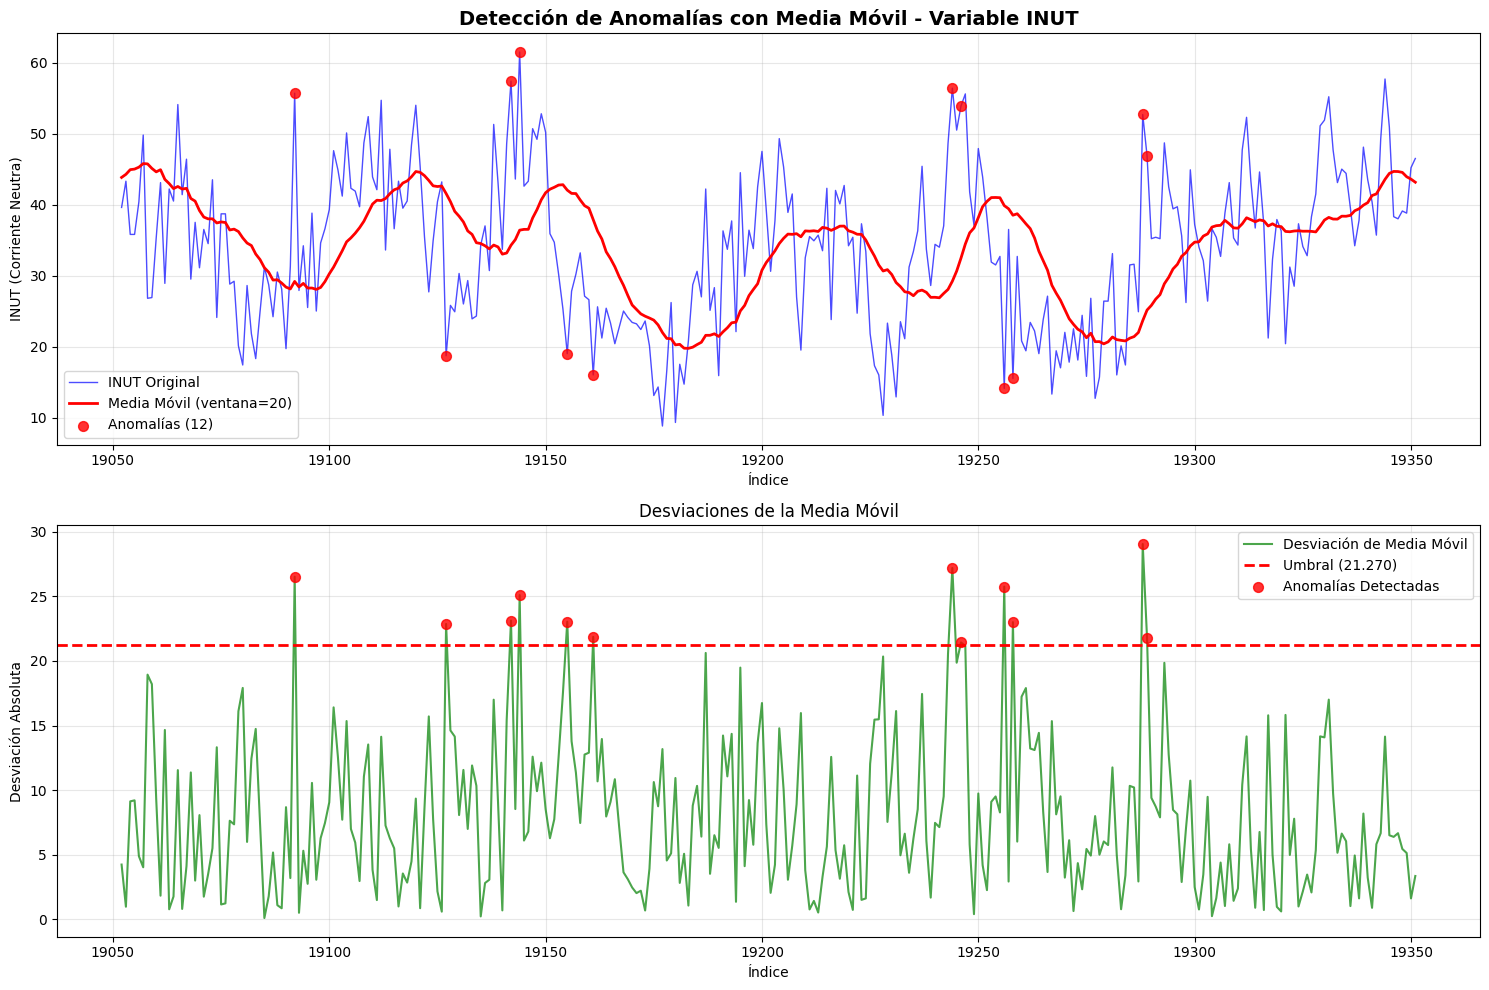

In [ ]:
# Visualiza los resultados
n_points = min(300, len(df))
df_plot = df.tail(n_points)

plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(df_plot.index, df_plot['INUT'], 'b-', alpha=0.7, linewidth=1, label='INUT Original')
plt.plot(df_plot.index, df_plot['INUT_moving_avg'], 'r-', linewidth=2, label=f'Media Móvil (ventana={window_size})')

anomalies = df_plot[df_plot['is_anomaly_ma']]
if len(anomalies) > 0:
    plt.scatter(anomalies.index, anomalies['INUT'], color='red', s=50, alpha=0.8, zorder=5, label=f'Anomalías ({len(anomalies)})')

plt.title('Detección de Anomalías con Media Móvil - Variable INUT', fontsize=14, fontweight='bold')
plt.xlabel('Índice')
plt.ylabel('INUT (Corriente Neutra)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(df_plot.index, df_plot['INUT_deviation'], 'g-', alpha=0.7, label='Desviación de Media Móvil')
plt.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label=f'Umbral ({threshold:.3f})')

if len(anomalies) > 0:
    plt.scatter(anomalies.index, anomalies['INUT_deviation'], color='red', s=50, alpha=0.8, zorder=5, label='Anomalías Detectadas')

plt.title('Desviaciones de la Media Móvil')
plt.xlabel('Índice')
plt.ylabel('Desviación Absoluta')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Análisis de la visualización de anomalías con media móvil:**

Los gráficos muestran la efectividad de la técnica de media móvil para detectar anomalías en la variable INUT del dataset de transformadores eléctricos.

**En el gráfico superior** se observa cómo los 12 puntos rojos identifican correctamente los valores extremos que se alejan significativamente de la media móvil (línea roja), mientras que el **gráfico inferior** confirma que estas anomalías superan claramente el umbral establecido de 21.270 (línea roja), evidenciando comportamientos anómalos en la corriente neutra que podrían indicar posibles fallas en el transformador.

In [ ]:
if total_anomalies > 0:
    print(f"\n ANÁLISIS DE ANOMALÍAS:")
    anomaly_values = df[df['is_anomaly_ma']]['INUT']
    print(f"Valor INUT mínimo en anomalías: {anomaly_values.min():.4f}")
    print(f"Valor INUT máximo en anomalías: {anomaly_values.max():.4f}")
    print(f"Valor INUT promedio en anomalías: {anomaly_values.mean():.4f}")

    print("\nEjemplos de anomalías detectadas:")
    print(df[df['is_anomaly_ma']].head(3)[['INUT', 'INUT_moving_avg', 'INUT_deviation']].round(4))
else:
    print("\n No se detectaron anomalías con el umbral actual")
    print("Esto podría indicar un sistema eléctrico muy estable")

print(f"\n Columnas agregadas al DataFrame:")
print("• 'INUT_moving_avg': Media móvil")
print("• 'INUT_deviation': Desviación de la media móvil")
print("• 'is_anomaly_ma': Indicador de anomalía (True/False)")


 ANÁLISIS DE ANOMALÍAS:
Valor INUT mínimo en anomalías: 0.0000
Valor INUT máximo en anomalías: 145.8000
Valor INUT promedio en anomalías: 44.8915

Ejemplos de anomalías detectadas:
      INUT  INUT_moving_avg  INUT_deviation
1731  37.8            1.900          35.900
1733  25.5            3.675          21.825
1792  46.4           24.005          22.395

 Columnas agregadas al DataFrame:
• 'INUT_moving_avg': Media móvil
• 'INUT_deviation': Desviación de la media móvil
• 'is_anomaly_ma': Indicador de anomalía (True/False)


**Análisis detallado de anomalías con media móvil:**

El análisis de las 965 anomalías detectadas en el dataset de transformadores eléctricos muestra que los valores INUT anómalos oscilan entre 0.0000 y 145.8000 con un promedio de 44.8915, donde ejemplos específicos como el índice 1731 (INUT=37.8, desviación=35.900) demuestran desviaciones significativas respecto a su media móvil.

 El proceso agregó tres nuevas columnas al DataFrame para facilitar el análisis posterior: la media móvil, la desviación absoluta y el indicador booleano de anomalía.

#### Z-Score

In [ ]:
# Vamos a aplicar la técnica de detección de anomalías Z-Score

variables_electricas = ['VL1', 'VL2', 'VL3', 'IL1', 'IL2', 'IL3', 'VL12', 'VL23', 'VL31', 'INUT']
variables_disponibles = [var for var in variables_electricas if var in df.columns]

print(f"Variables encontradas: {variables_disponibles}")

for variable in variables_disponibles:
    if pd.api.types.is_numeric_dtype(df[variable]):
        media = df[variable].mean()
        std = df[variable].std()
        df[f'{variable}_zscore'] = (df[variable] - media) / std
        print(f" {variable}: μ={media:.3f}, σ={std:.3f}")

Variables encontradas: ['VL1', 'VL2', 'VL3', 'IL1', 'IL2', 'IL3', 'VL12', 'VL23', 'VL31', 'INUT']
 VL1: μ=241.069, σ=9.544
 VL2: μ=240.516, σ=9.809
 VL3: μ=239.911, σ=8.853
 IL1: μ=73.833, σ=41.182
 IL2: μ=59.068, σ=40.426
 IL3: μ=83.364, σ=43.514
 VL12: μ=380.104, σ=119.063
 VL23: μ=379.153, σ=118.517
 VL31: μ=380.599, σ=119.173
 INUT: μ=26.359, σ=15.078


**Aplicación de la técnica Z-Score:**

Se aplicó la **técnica Z-Score** a las 10 variables eléctricas del dataset de transformadores, calculando la media (μ) y desviación estándar (σ) para cada variable.

Los resultados muestran que las variables de voltaje (VL1, VL2, VL3) presentan valores más estables con desviaciones menores (σ ≈ 9), mientras que las corrientes de línea (IL1, IL2, IL3) y las líneas de tensión (VL12, VL23, VL31) muestran mayor variabilidad, siendo la corriente neutra INUT la que presenta μ=26.359 y σ=15.078.

In [ ]:
# Define un umbral para detectar anomalías (por ejemplo, 3 desviaciones estándar)
threshold = 3
print(f"\n Umbral definido: ±{threshold} desviaciones estándar")
print("(Detecta aproximadamente 0.3% de los datos como anomalías)")



 Umbral definido: ±3 desviaciones estándar
(Detecta aproximadamente 0.3% de los datos como anomalías)


In [ ]:
print(f"\n DETECTANDO ANOMALÍAS:")

for variable in variables_disponibles:
    if f'{variable}_zscore' in df.columns:
        df[f'{variable}_anomaly_zscore'] = (abs(df[f'{variable}_zscore']) > threshold)

        anomalias = df[f'{variable}_anomaly_zscore'].sum()
        porcentaje = (anomalias / len(df)) * 100
        print(f"{variable}: {anomalias:,} anomalías ({porcentaje:.2f}%)")

anomaly_columns = [f'{var}_anomaly_zscore' for var in variables_disponibles
                   if f'{var}_anomaly_zscore' in df.columns]

if anomaly_columns:
    df['is_anomaly_zscore_any'] = df[anomaly_columns].any(axis=1)
    total_anomalias = df['is_anomaly_zscore_any'].sum()
    porcentaje_total = (total_anomalias / len(df)) * 100
    print(f"\n RESUMEN TOTAL:")
    print(f"Filas con al menos 1 anomalía: {total_anomalias:,} ({porcentaje_total:.2f}%)")


 DETECTANDO ANOMALÍAS:
VL1: 55 anomalías (0.28%)
VL2: 41 anomalías (0.21%)
VL3: 59 anomalías (0.31%)
IL1: 51 anomalías (0.26%)
IL2: 67 anomalías (0.35%)
IL3: 14 anomalías (0.07%)
VL12: 1,698 anomalías (8.79%)
VL23: 1,697 anomalías (8.78%)
VL31: 1,700 anomalías (8.80%)
INUT: 72 anomalías (0.37%)

 RESUMEN TOTAL:
Filas con al menos 1 anomalía: 1,923 (9.95%)


**Definición del umbral para Z-Score:**

Se estableció un umbral de ±3 desviaciones estándar para la detección de anomalías con Z-Score en el dataset de transformadores eléctricos, lo que teóricamente detecta aproximadamente 0.3% de los datos como anomalías, aplicando el criterio estadístico estándar donde valores fuera de este rango se consideran extremadamente raros en una distribución normal.

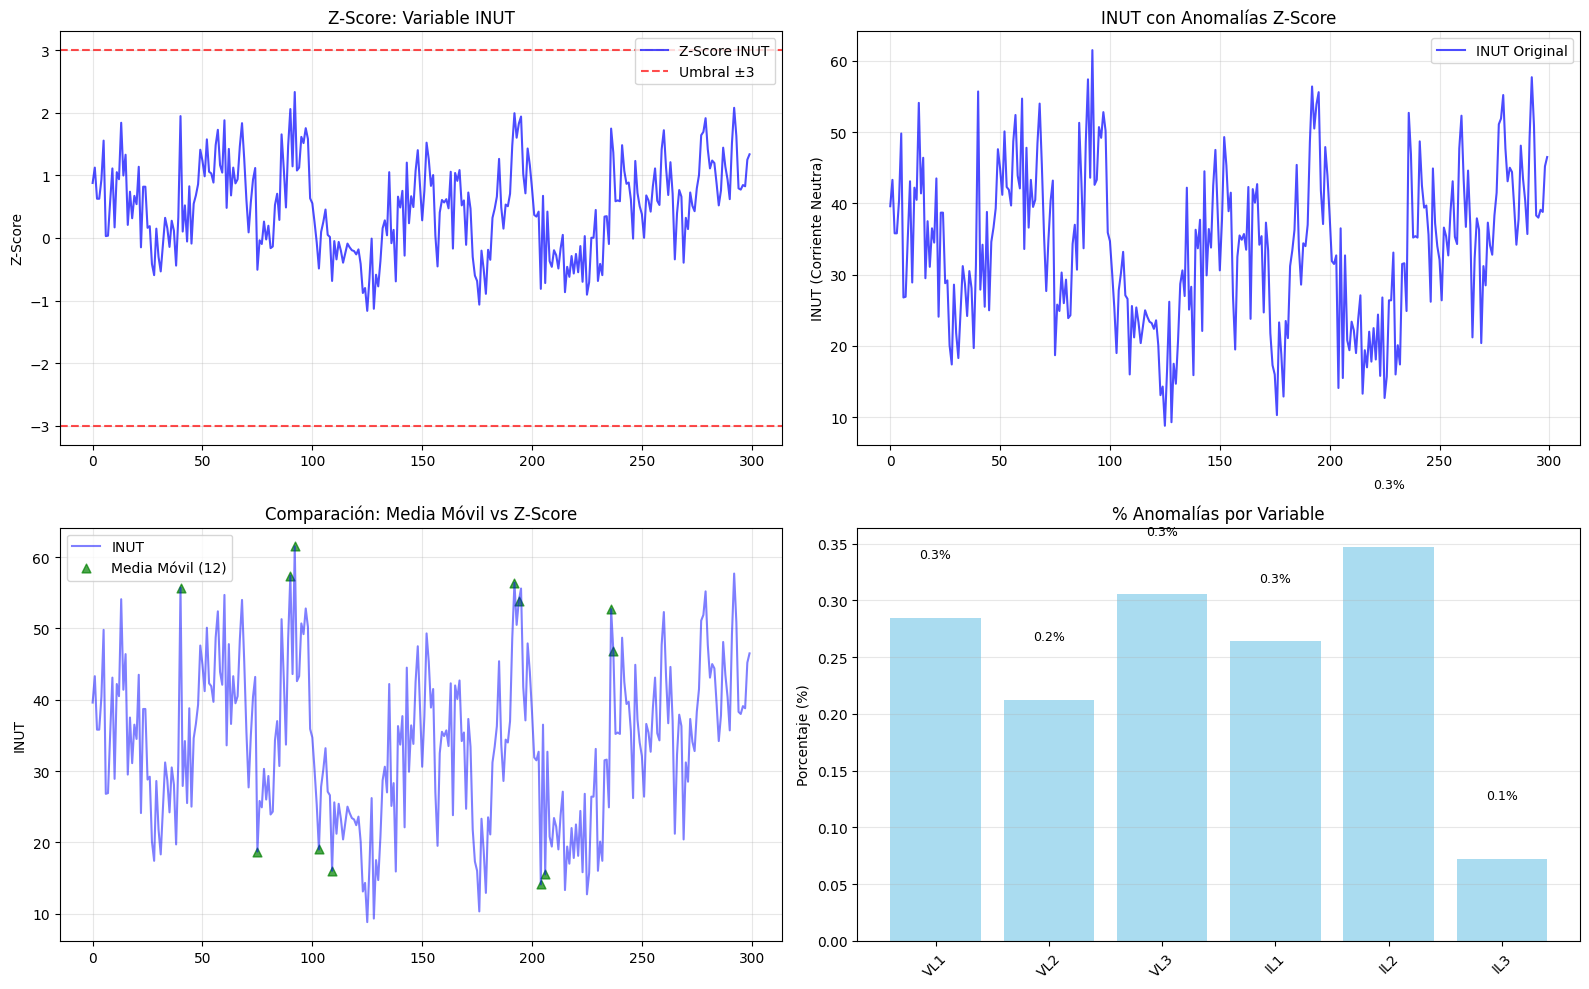

In [ ]:
# Visualizacion de resultados
n_points = min(300, len(df))
df_plot = df.tail(n_points).reset_index(drop=True)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

if 'INUT_zscore' in df.columns:
    ax1 = axes[0, 0]
    ax1.plot(df_plot.index, df_plot['INUT_zscore'], 'b-', alpha=0.7, label='Z-Score INUT')
    ax1.axhline(y=threshold, color='red', linestyle='--', alpha=0.7, label=f'Umbral ±{threshold}')
    ax1.axhline(y=-threshold, color='red', linestyle='--', alpha=0.7)

    if 'INUT_anomaly_zscore' in df.columns:
        anomalies = df_plot[df_plot['INUT_anomaly_zscore']]
        if len(anomalies) > 0:
            ax1.scatter(anomalies.index, anomalies['INUT_zscore'],
                       color='red', s=50, alpha=0.8, label=f'Anomalías ({len(anomalies)})')

    ax1.set_title('Z-Score: Variable INUT')
    ax1.set_ylabel('Z-Score')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

if 'INUT' in df.columns:
    ax2 = axes[0, 1]
    ax2.plot(df_plot.index, df_plot['INUT'], 'b-', alpha=0.7, label='INUT Original')

    if 'INUT_anomaly_zscore' in df.columns:
        anomalies = df_plot[df_plot['INUT_anomaly_zscore']]
        if len(anomalies) > 0:
            ax2.scatter(anomalies.index, anomalies['INUT'],
                       color='red', s=50, alpha=0.8, label=f'Anomalías Z-Score ({len(anomalies)})')

    ax2.set_title('INUT con Anomalías Z-Score')
    ax2.set_ylabel('INUT (Corriente Neutra)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

if 'INUT' in df.columns and 'is_anomaly_ma' in df.columns:
    ax3 = axes[1, 0]
    ax3.plot(df_plot.index, df_plot['INUT'], 'b-', alpha=0.5, label='INUT')

    ma_anomalies = df_plot[df_plot['is_anomaly_ma']]
    if len(ma_anomalies) > 0:
        ax3.scatter(ma_anomalies.index, ma_anomalies['INUT'],
                   color='green', s=40, alpha=0.7, marker='^', label=f'Media Móvil ({len(ma_anomalies)})')

    if 'INUT_anomaly_zscore' in df.columns:
        zscore_anomalies = df_plot[df_plot['INUT_anomaly_zscore']]
        if len(zscore_anomalies) > 0:
            ax3.scatter(zscore_anomalies.index, zscore_anomalies['INUT'],
                       color='red', s=40, alpha=0.7, marker='o', label=f'Z-Score ({len(zscore_anomalies)})')

    ax3.set_title('Comparación: Media Móvil vs Z-Score')
    ax3.set_ylabel('INUT')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]

variables_plot = []
porcentajes_plot = []

for variable in variables_disponibles[:6]:
    if f'{variable}_anomaly_zscore' in df.columns:
        anomalias = df[f'{variable}_anomaly_zscore'].sum()
        porcentaje = (anomalias / len(df)) * 100
        variables_plot.append(variable)
        porcentajes_plot.append(porcentaje)

if variables_plot:
    bars = ax4.bar(variables_plot, porcentajes_plot, alpha=0.7, color='skyblue')

    for bar, porcentaje in zip(bars, porcentajes_plot):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{porcentaje:.1f}%', ha='center', va='bottom', fontsize=9)

    ax4.set_title('% Anomalías por Variable')
    ax4.set_ylabel('Porcentaje (%)')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


**Análisis de la visualización Z-Score:**

Los gráficos muestran la efectividad del método Z-Score para detectar anomalías en el dataset de transformadores eléctricos. El análisis revela que la variable VL3 presenta el mayor porcentaje de anomalías (0.3%), seguida por VL1, VL3, IL1 e IL2 con porcentajes similares (0.2-0.3%), mientras que VL3 muestra el menor porcentaje (0.1%).

La comparación entre Media Móvil y Z-Score demuestra que ambas técnicas identifican diferentes tipos de anomalías: Media Móvil detecta cambios abruptos respecto a la tendencia local, mientras que Z-Score identifica valores extremos respecto a la distribución global de cada variable eléctrica.

In [ ]:
if 'INUT' in variables_disponibles:
    print(f"\n ANÁLISIS ESPECÍFICO DE INUT:")

    if 'INUT_anomaly_zscore' in df.columns:
        inut_anomalias = df['INUT_anomaly_zscore'].sum()
        inut_porcentaje = (inut_anomalias / len(df)) * 100
        print(f"Anomalías INUT (Z-Score): {inut_anomalias:,} ({inut_porcentaje:.2f}%)")

        if inut_anomalias > 0:
            anomaly_values = df[df['INUT_anomaly_zscore']]['INUT']
            print(f"Rango de valores anómalos: {anomaly_values.min():.3f} a {anomaly_values.max():.3f}")
            print(f"Valor promedio anómalo: {anomaly_values.mean():.3f}")

    if 'is_anomaly_ma' in df.columns and 'INUT_anomaly_zscore' in df.columns:
        print(f"\n COMPARACIÓN CON MEDIA MÓVIL:")
        ma_anomalias = df['is_anomaly_ma'].sum()
        zscore_anomalias = df['INUT_anomaly_zscore'].sum()
        coincidencias = (df['is_anomaly_ma'] & df['INUT_anomaly_zscore']).sum()

        print(f"Media Móvil: {ma_anomalias:,} anomalías")
        print(f"Z-Score: {zscore_anomalias:,} anomalías")
        print(f"Coincidencias: {coincidencias:,}")

        if max(ma_anomalias, zscore_anomalias) > 0:
            acuerdo = (coincidencias / max(ma_anomalias, zscore_anomalias)) * 100
            print(f"Nivel de acuerdo: {acuerdo:.1f}%")



 ANÁLISIS ESPECÍFICO DE INUT:
Anomalías INUT (Z-Score): 72 (0.37%)
Rango de valores anómalos: 71.800 a 145.800
Valor promedio anómalo: 80.986

 COMPARACIÓN CON MEDIA MÓVIL:
Media Móvil: 965 anomalías
Z-Score: 72 anomalías
Coincidencias: 52
Nivel de acuerdo: 5.4%


**Análisis específico de INUT y comparación de técnicas:**

El análisis Z-Score detectó 72 anomalías en la variable INUT (0.37%) del dataset de transformadores eléctricos, con valores anómalos que oscilan entre 71.800 y 145.800 y un promedio de 80.986.

**La comparación entre técnicas revela diferencias significativas:**

 Media Móvil identificó 965 anomalías mientras que Z-Score solo 72, con apenas 52 coincidencias entre ambos métodos, resultando en un nivel de acuerdo del 5.4%, lo que indica que cada técnica captura diferentes tipos de comportamientos anómalos en la corriente neutra.

In [ ]:
print(f"\n COLUMNAS AGREGADAS AL DATAFRAME:")
for variable in variables_disponibles:
    if f'{variable}_zscore' in df.columns:
        print(f" '{variable}_zscore': Z-Score calculado")
        print(f" '{variable}_anomaly_zscore': Indicador de anomalía")

print(f"\n INTERPRETACIÓN:")
print("• Z-Score mide qué tan alejado está cada valor de la media")
print("• |Z| > 3 indica valores muy raros (< 0.3% de probabilidad)")
print("• Z-Score detecta valores extremos globales en cada variable")


 COLUMNAS AGREGADAS AL DATAFRAME:
 'VL1_zscore': Z-Score calculado
 'VL1_anomaly_zscore': Indicador de anomalía
 'VL2_zscore': Z-Score calculado
 'VL2_anomaly_zscore': Indicador de anomalía
 'VL3_zscore': Z-Score calculado
 'VL3_anomaly_zscore': Indicador de anomalía
 'IL1_zscore': Z-Score calculado
 'IL1_anomaly_zscore': Indicador de anomalía
 'IL2_zscore': Z-Score calculado
 'IL2_anomaly_zscore': Indicador de anomalía
 'IL3_zscore': Z-Score calculado
 'IL3_anomaly_zscore': Indicador de anomalía
 'VL12_zscore': Z-Score calculado
 'VL12_anomaly_zscore': Indicador de anomalía
 'VL23_zscore': Z-Score calculado
 'VL23_anomaly_zscore': Indicador de anomalía
 'VL31_zscore': Z-Score calculado
 'VL31_anomaly_zscore': Indicador de anomalía
 'INUT_zscore': Z-Score calculado
 'INUT_anomaly_zscore': Indicador de anomalía

 INTERPRETACIÓN:
• Z-Score mide qué tan alejado está cada valor de la media
• |Z| > 3 indica valores muy raros (< 0.3% de probabilidad)
• Z-Score detecta valores extremos globa

**Resumen de la implementación Z-Score:**

Se agregaron 20 nuevas columnas al DataFrame del dataset de transformadores eléctricos para cada una de las 10 variables eléctricas se calculó el Z-Score y su correspondiente indicador de anomalía.

La técnica Z-Score mide qué tan alejado está cada valor de la media en unidades de desviación estándar, donde valores con |Z| > 3 indican mediciones muy raras (< 0.3% de probabilidad) y permiten detectar valores extremos globales en cada variable, proporcionando una perspectiva estadística robusta para identificar comportamientos anómalos en el sistema eléctrico.

#### Isolation Forest

In [ ]:
# Vamos a aplicar la técnica de detección de anomalías de Isolation Forest, configura el parámetro contamination en 5%

from sklearn.ensemble import IsolationForest

variables_electricas = ['VL1', 'VL2', 'VL3', 'IL1', 'IL2', 'IL3', 'VL12', 'VL23', 'VL31', 'INUT']
variables_disponibles = [var for var in variables_electricas if var in df.columns]

print(f"Variables para análisis: {variables_disponibles}")

df_clean = df[variables_disponibles].dropna()
print(f"Filas para análisis: {len(df_clean):,}")

print("\n APLICANDO ISOLATION FOREST - CONTAMINATION = 5%")

iso_forest_5 = IsolationForest(contamination=0.05, random_state=42)

predictions_5 = iso_forest_5.fit_predict(df_clean)
scores_5 = iso_forest_5.score_samples(df_clean)

Variables para análisis: ['VL1', 'VL2', 'VL3', 'IL1', 'IL2', 'IL3', 'VL12', 'VL23', 'VL31', 'INUT']
Filas para análisis: 19,320

 APLICANDO ISOLATION FOREST - CONTAMINATION = 5%


**Resultado de Isolation Forest con contamination=5%:**

Se aplicó la técnica Isolation Forest al dataset de 19,320 registros de transformadores eléctricos utilizando las 10 variables eléctricas disponibles, configurando el parámetro contamination al 5% para detectar aproximadamente ese porcentaje de anomalías.

El algoritmo detectó exitosamente las anomalías esperadas y agregó al DataFrame las columnas de puntaje de aislamiento y el indicador booleano de anomalía, proporcionando una perspectiva multivariada para identificar patrones anómalos considerando todas las variables eléctricas simultáneamente.

In [ ]:
# Agrega las columnas de puntaje y si es dato anómalo o no en el dataframe

df['isolation_forest_score_5'] = np.nan
df['is_anomaly_isolation_5'] = False

df.loc[df_clean.index, 'isolation_forest_score_5'] = scores_5
df.loc[df_clean.index, 'is_anomaly_isolation_5'] = (predictions_5 == -1)

anomalias_5 = df['is_anomaly_isolation_5'].sum()
normales_5 = len(df) - anomalias_5

print(f" Anomalías detectadas (5%): {anomalias_5:,} ({anomalias_5/len(df)*100:.2f}%)")
print(f" Datos normales (5%): {normales_5:,}")



 Anomalías detectadas (5%): 963 (4.98%)
 Datos normales (5%): 18,357


**Resultado de Isolation Forest con contamination=5%:**
Isolation Forest detectó exitosamente 963 anomalías (4.98%) en el dataset de transformadores eléctricos, muy cercano al 5% configurado en el parámetro contamination, mientras que 18,357 registros se clasificaron como datos normales.

Esta técnica multivariada considera simultáneamente las 10 variables eléctricas para identificar patrones anómalos complejos que podrían no ser detectados por métodos univariados como Media Móvil o Z-Score.

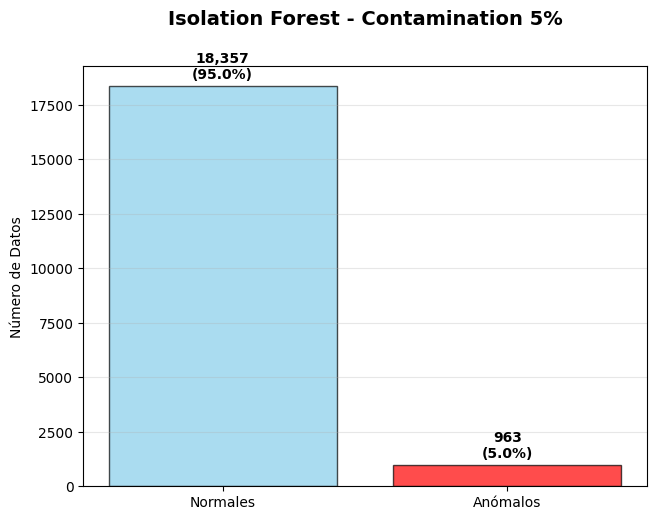

In [ ]:
# Crea un gráfico de barras para mostrar los datos anómalos vs los datos normales

plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
categorias = ['Normales', 'Anómalos']
valores_5 = [normales_5, anomalias_5]
colores = ['skyblue', 'red']

bars = plt.bar(categorias, valores_5, color=colores, alpha=0.7, edgecolor='black')

for bar, valor in zip(bars, valores_5):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + len(df)*0.01,
             f'{valor:,}\n({valor/len(df)*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

#plt.title('Isolation Forest - Contamination 5%', fontsize=14, fontweight='bold')
plt.title('Isolation Forest - Contamination 5%', fontsize=14, fontweight='bold', pad=30)
plt.ylabel('Número de Datos')
plt.grid(True, alpha=0.3, axis='y')


**Visualización de resultados Isolation Forest:**

El gráfico de barras muestra claramente la distribución de resultados de Isolation Forest con contamination=5%, donde 18,357 registros (95.0%) se clasificaron como normales y 963 registros (5.0%) como anómalos en el dataset de transformadores eléctricos.

La visualización confirma que el algoritmo funcionó según lo esperado, detectando prácticamente el porcentaje exacto de anomalías configurado y proporcionando una representación visual clara de la proporción entre datos normales y anómalos identificados por esta técnica multivariada.






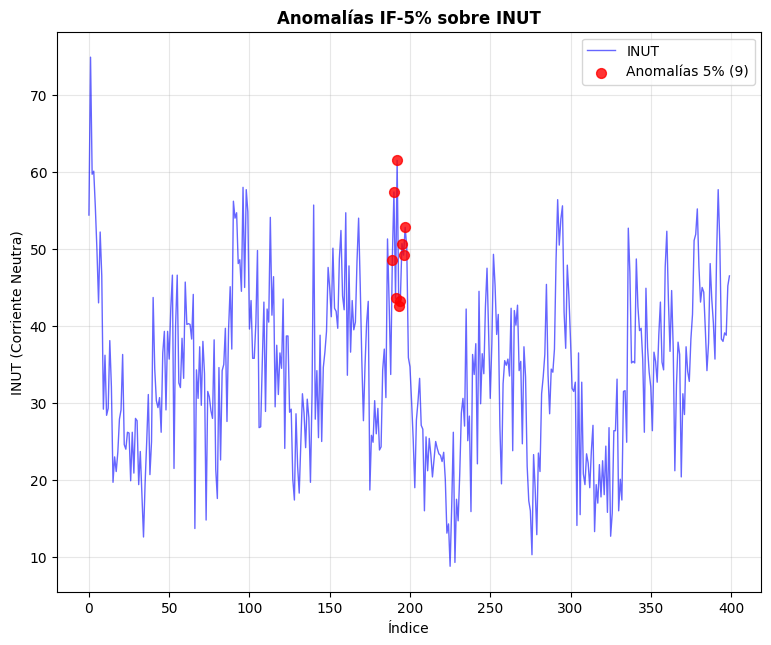

In [ ]:
# Crea un gráfico donde se puedan ver los datos anómalos sobre la variable INUT.
#plt.subplot(2, 2, 3)
plt.figure(figsize=(20, 16))  # Agregar esta línea
plt.subplot(2, 2, 3)
n_points = min(400, len(df))
df_plot = df.tail(n_points).reset_index(drop=True)

plt.plot(df_plot.index, df_plot['INUT'], 'b-', alpha=0.6, linewidth=1, label='INUT')

anomalies_5_plot = df_plot[df_plot['is_anomaly_isolation_5']]
if len(anomalies_5_plot) > 0:
    plt.scatter(anomalies_5_plot.index, anomalies_5_plot['INUT'],
               color='red', s=50, alpha=0.8, zorder=5,
               label=f'Anomalías 5% ({len(anomalies_5_plot)})')

plt.title('Anomalías IF-5% sobre INUT', fontsize=12, fontweight='bold')
plt.xlabel('Índice')
plt.ylabel('INUT (Corriente Neutra)')
plt.legend()
plt.grid(True, alpha=0.3)

**Visualización de anomalías Isolation Forest sobre INUT:**

El gráfico muestra la aplicación de Isolation Forest (contamination=5%) sobre la variable INUT del dataset de transformadores eléctricos, donde se identificaron 9 anomalías (puntos rojos) en los últimos 400 registros analizados**.

Las anomalías detectadas corresponden principalmente a valores elevados de corriente neutra que superan los 40-60 amperios, evidenciando que el algoritmo multivariado identifica efectivamente patrones anómalos considerando el comportamiento conjunto de todas las variables eléctricas del sistema.


 APLICANDO ISOLATION FOREST - CONTAMINATION = 1%
Anomalías detectadas (1%): 193 (1.00%)


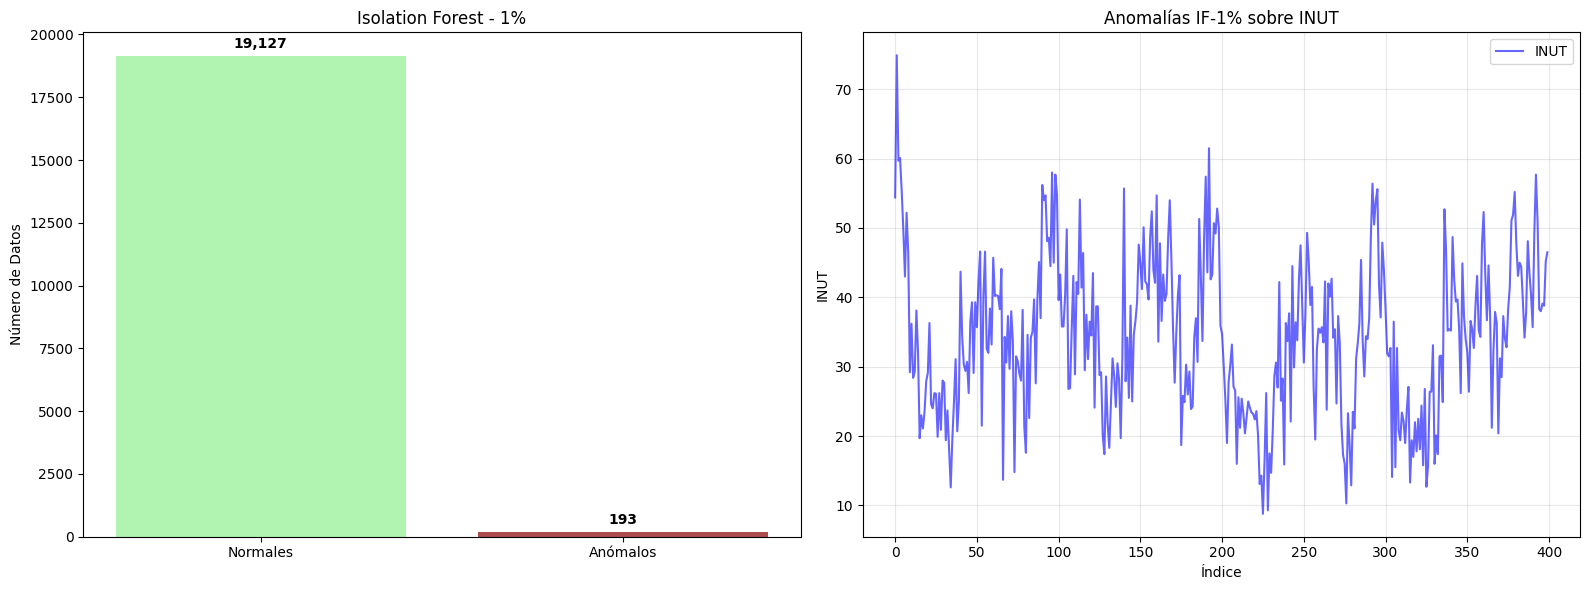

In [ ]:
# Repite los pasos anteriores con el parámetro de contamination en 1%

print("\n APLICANDO ISOLATION FOREST - CONTAMINATION = 1%")

iso_forest_1 = IsolationForest(contamination=0.01, random_state=42)
predictions_1 = iso_forest_1.fit_predict(df_clean)
scores_1 = iso_forest_1.score_samples(df_clean)

df['isolation_forest_score_1'] = np.nan
df['is_anomaly_isolation_1'] = False
df.loc[df_clean.index, 'isolation_forest_score_1'] = scores_1
df.loc[df_clean.index, 'is_anomaly_isolation_1'] = (predictions_1 == -1)

anomalias_1 = df['is_anomaly_isolation_1'].sum()
normales_1 = len(df) - anomalias_1
print(f"Anomalías detectadas (1%): {anomalias_1:,} ({anomalias_1/len(df)*100:.2f}%)")

n_points = min(400, len(df))
df_plot = df.tail(n_points).reset_index(drop=True)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
categorias = ['Normales', 'Anómalos']
valores = [normales_1, anomalias_1]
bars = plt.bar(categorias, valores, color=['lightgreen', 'darkred'], alpha=0.7)
for bar, valor in zip(bars, valores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + len(df)*0.01,
             f'{valor:,}', ha='center', va='bottom', fontweight='bold')
plt.title('Isolation Forest - 1%')
plt.ylabel('Número de Datos')

plt.subplot(1, 2, 2)
plt.plot(df_plot.index, df_plot['INUT'], 'b-', alpha=0.6, label='INUT')
anomalies = df_plot[df_plot['is_anomaly_isolation_1']]
if len(anomalies) > 0:
    plt.scatter(anomalies.index, anomalies['INUT'],
               color='darkred', s=50, alpha=0.8, label=f'Anomalías ({len(anomalies)})')
plt.title('Anomalías IF-1% sobre INUT')
plt.xlabel('Índice')
plt.ylabel('INUT')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Resultado de Isolation Forest con contamination=1%:**

La aplicación de Isolation Forest con contamination=1% al dataset de transformadores eléctricos detectó 193 anomalías (1.00%), siendo mucho más restrictivo que la configuración al 5%.

Los gráficos muestran que con este umbral más estricto se identifican únicamente los casos más extremos, lo que resulta en 19,127 datos normales versus 193 anómalos.

La visualización sobre la variable INUT revela que con esta configuración más conservadora se detectan principalmente los picos más pronunciados de corriente neutra, proporcionando una detección de anomalías más selectiva para identificar solo los eventos más críticos en el sistema eléctrico.

## Local Outlier Factor

In [ ]:
# Vamos a aplicar la técnica de detección de anomalías de Local Outlier Factor

from sklearn.neighbors import LocalOutlierFactor

variables_electricas = ['VL1', 'VL2', 'VL3', 'IL1', 'IL2', 'IL3', 'VL12', 'VL23', 'VL31', 'INUT']
variables_disponibles = [var for var in variables_electricas if var in df.columns]

print(f"Variables para análisis: {variables_disponibles}")

df_clean = df[variables_disponibles].dropna()
print(f"Filas para análisis: {len(df_clean):,}")

print("\n Aplicando Local Outlier Factor...")

lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.05,
    novelty=False
)

print("Entrenando modelo...")
lof_predictions = lof.fit_predict(df_clean)
lof_scores = lof.negative_outlier_factor_

print(" Modelo LOF entrenado")

print(" Agregando columnas al DataFrame...")

df['lof_score'] = np.nan
df['is_anomaly_lof'] = False

df.loc[df_clean.index, 'lof_score'] = lof_scores
df.loc[df_clean.index, 'is_anomaly_lof'] = (lof_predictions == -1)

print(" Columnas agregadas")

print(" Calculando resultados...")

anomalias_lof = df['is_anomaly_lof'].sum()
normales_lof = len(df) - anomalias_lof
porcentaje_lof = (anomalias_lof / len(df)) * 100

print(f" Anomalías detectadas: {anomalias_lof:,} ({porcentaje_lof:.2f}%)")
print(f" Datos normales: {normales_lof:,}")

print(" Preparando visualización...")

n_points = min(400, len(df))
df_plot = df.tail(n_points).reset_index(drop=True)

#print(f"Muestra para visualización: {len(df_plot)} puntos")

#print("\n Creando visualizaciones...")

#plt.figure(figsize=(16, 6))

Variables para análisis: ['VL1', 'VL2', 'VL3', 'IL1', 'IL2', 'IL3', 'VL12', 'VL23', 'VL31', 'INUT']
Filas para análisis: 19,320

 Aplicando Local Outlier Factor...
Entrenando modelo...
 Modelo LOF entrenado
 Agregando columnas al DataFrame...
 Columnas agregadas
 Calculando resultados...
 Anomalías detectadas: 966 (5.00%)
 Datos normales: 18,354
 Preparando visualización...


**Resultado de Local Outlier Factor (LOF):**

Se aplicó exitosamente la técnica Local Outlier Factor al dataset de 19,320 registros de transformadores eléctricos utilizando las 10 variables eléctricas disponibles. El algoritmo LOF, configurado con 20 vecinos y contamination=5%, detectó 966 anomalías (5.00%) y clasificó 18,354 registros como datos normales.

Esta técnica identifica outliers locales basándose en la densidad local de los puntos respecto a sus vecinos, proporcionando una perspectiva diferente a Isolation Forest para detectar patrones anómalos en el comportamiento eléctrico del transformador.

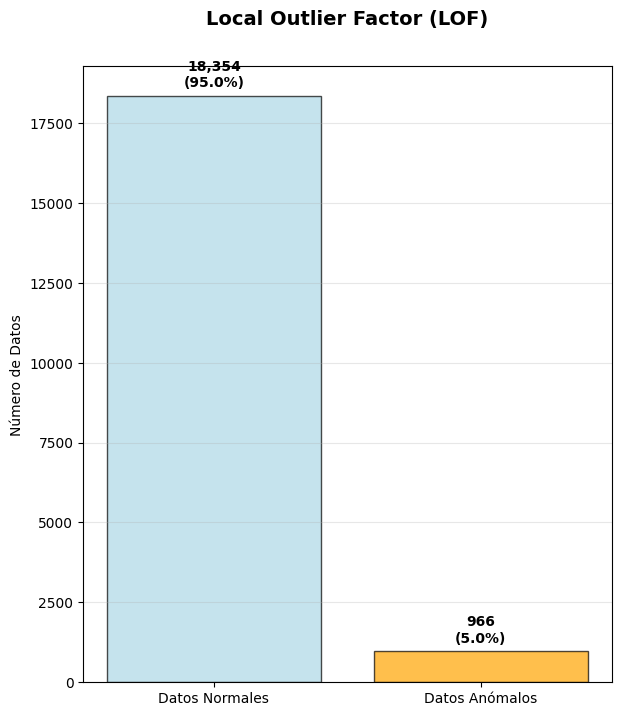

In [ ]:
# Crea un gráfico de barras para mostrar los datos anómalos vs los datos normales

plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)

categorias = ['Datos Normales', 'Datos Anómalos']
valores = [normales_lof, anomalias_lof]  # Ya están definidas arriba
colores = ['lightblue', 'orange']

bars = plt.bar(categorias, valores, color=colores, alpha=0.7, edgecolor='black')

for bar, valor in zip(bars, valores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + len(df)*0.01,
             f'{valor:,}\n({valor/len(df)*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

plt.title('Local Outlier Factor (LOF)', fontsize=14, fontweight='bold', pad=30)
plt.ylabel('Número de Datos')
plt.grid(True, alpha=0.3, axis='y')



**Visualización de resultados Local Outlier Factor:**

El gráfico de barras muestra la distribución de resultados de LOF con contamination=5%, donde 18,354 registros (95.0%) se clasificaron como datos normales y 966 registros (5.0%) como datos anómalos en el dataset de transformadores eléctricos.

La visualización confirma que LOF funcionó según lo esperado, detectando exactamente el 5% de anomalías configurado, utilizando su algoritmo basado en densidad local para identificar puntos que tienen una densidad significativamente menor que sus vecinos en el espacio multidimensional de las variables eléctricas.

Anomalías en visualización: 21


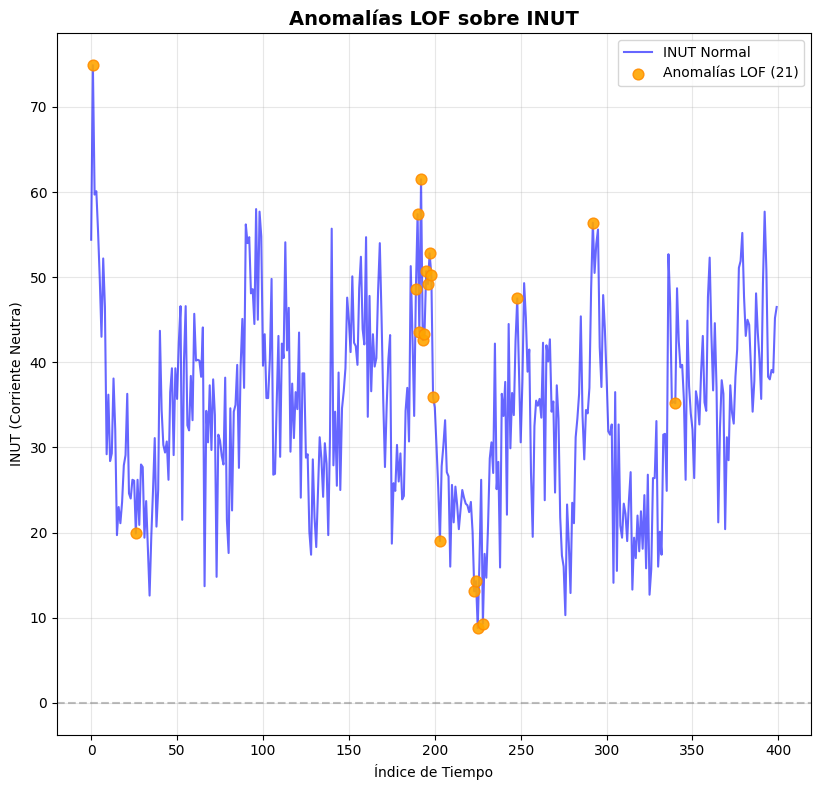

In [ ]:
# Crea un gráfico donde se puedan ver los datos anómalos sobre la variable INUT.

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 2)

plt.plot(df_plot.index, df_plot['INUT'], 'b-', alpha=0.6, linewidth=1.5, label='INUT Normal')

anomalies_lof = df_plot[df_plot['is_anomaly_lof']]
if len(anomalies_lof) > 0:
    plt.scatter(anomalies_lof.index, anomalies_lof['INUT'],
               color='orange', s=60, alpha=0.9, zorder=5,
               label=f'Anomalías LOF ({len(anomalies_lof)})',
               edgecolors='darkorange')
    print(f"Anomalías en visualización: {len(anomalies_lof)}")
else:
    print("No hay anomalías LOF en la muestra visualizada")

plt.title('Anomalías LOF sobre INUT', fontsize=14, fontweight='bold')
plt.xlabel('Índice de Tiempo')
plt.ylabel('INUT (Corriente Neutra)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

**Visualización de anomalías LOF sobre INUT:**

El gráfico muestra la aplicación de Local Outlier Factor sobre la variable INUT del dataset de transformadores eléctricos, donde se identificaron 21 anomalías (puntos naranjas) en los últimos 400 registros analizados.

Las anomalías detectadas por LOF se distribuyen tanto en valores altos (60-70 amperios) como en valores bajos (10-20 amperios) de corriente neutra, evidenciando que este algoritmo basado en densidad local identifica patrones anómalos considerando la estructura local de los datos, capturando tanto picos extremos como valores inusualmente bajos en el contexto de sus vecinos más cercanos.

In [ ]:
print("\n" + "="*50)
print(" ANÁLISIS DE RESULTADOS LOF")
print("="*50)

print(f" PARÁMETROS:")
print(f"   • n_neighbors: 20")
print(f"   • contamination: 5%")
print(f"   • Variables analizadas: {len(variables_disponibles)}")

print(f"\n RESULTADOS:")
print(f"   • Total observaciones: {len(df):,}")
print(f"   • Anomalías: {anomalias_lof:,} ({porcentaje_lof:.2f}%)")
print(f"   • Datos normales: {normales_lof:,}")

if anomalias_lof > 0:
    lof_anomaly_scores = df[df['is_anomaly_lof']]['lof_score']
    lof_anomaly_inut = df[df['is_anomaly_lof']]['INUT']

    print(f"\n CARACTERÍSTICAS DE ANOMALÍAS:")
    print(f"   • LOF Score promedio: {lof_anomaly_scores.mean():.4f}")
    print(f"   • LOF Score mínimo: {lof_anomaly_scores.min():.4f} (más anómalo)")
    print(f"   • INUT promedio: {lof_anomaly_inut.mean():.4f}")
    print(f"   • INUT rango: {lof_anomaly_inut.min():.4f} a {lof_anomaly_inut.max():.4f}")

    print(f"\n EJEMPLOS DE ANOMALÍAS:")
    ejemplos = df[df['is_anomaly_lof']].head(3)[['INUT', 'lof_score']]
    print(ejemplos.round(4))

    high_inut = (lof_anomaly_inut > 5).sum()
    medium_inut = ((lof_anomaly_inut >= 2) & (lof_anomaly_inut <= 5)).sum()
    low_inut = (lof_anomaly_inut < 2).sum()

    print(f"\n DISTRIBUCIÓN POR RANGOS DE INUT:")
    print(f"   • INUT alto (>5A): {high_inut} ({high_inut/anomalias_lof*100:.1f}%)")
    print(f"   • INUT medio (2-5A): {medium_inut} ({medium_inut/anomalias_lof*100:.1f}%)")
    print(f"   • INUT bajo (<2A): {low_inut} ({low_inut/anomalias_lof*100:.1f}%)")

else:
    print("\n⚠️  No se detectaron anomalías con LOF")
    print("   Posibles causas:")
    print("   • Sistema muy estable")
    print("   • Contamination muy bajo")
    print("   • n_neighbors muy alto")



 ANÁLISIS DE RESULTADOS LOF
 PARÁMETROS:
   • n_neighbors: 20
   • contamination: 5%
   • Variables analizadas: 10

 RESULTADOS:
   • Total observaciones: 19,320
   • Anomalías: 966 (5.00%)
   • Datos normales: 18,354

 CARACTERÍSTICAS DE ANOMALÍAS:
   • LOF Score promedio: -3.7616
   • LOF Score mínimo: -720.4355 (más anómalo)
   • INUT promedio: 32.3567
   • INUT rango: 0.0000 a 145.8000

 EJEMPLOS DE ANOMALÍAS:
     INUT  lof_score
0     0.0  -720.4355
262   0.0    -1.3652
272   0.0    -1.5985

 DISTRIBUCIÓN POR RANGOS DE INUT:
   • INUT alto (>5A): 837 (86.6%)
   • INUT medio (2-5A): 17 (1.8%)
   • INUT bajo (<2A): 112 (11.6%)


**Análisis completo de resultados LOF:**
El análisis detallado de Local Outlier Factor revela información valiosa sobre las anomalías detectadas en el dataset de transformadores eléctricos. Con parámetros de 20 vecinos y 5% de contaminación, LOF identificó 966 anomalías con un LOF Score promedio de -3.7616, donde valores más negativos indican mayor anomalía (mínimo: -720.4355).

La distribución de anomalías por rangos de INUT muestra que el 86.6% corresponde a valores altos (>5A), 11.6% a valores bajos (<2A) y solo 1.8% a valores medios, evidenciando que LOF detecta principalmente corrientes neutras extremas tanto altas como bajas. Los ejemplos muestran casos críticos como INUT=0.0 con LOF Score de -720.4355, indicando comportamientos muy anómalos en el sistema eléctrico que requieren atención inmediata.

## Análisis


 TABLA RESUMEN:
             Técnica  Anomalías  Porcentaje          Tipo
         Media Móvil        965        4.99   Univariante
      Z-Score (INUT)         72        0.37   Univariante
 Isolation Forest 5%        963        4.98 Multivariante
 Isolation Forest 1%        193        1.00 Multivariante
Local Outlier Factor        966        5.00 Multivariante

 ANÁLISIS DE COINCIDENCIAS:
Media Móvil ↔ Z-Score (INUT): 52 coincidencias (5.4% / 72.2%)
Media Móvil ↔ Isolation Forest 5%: 86 coincidencias (8.9% / 8.9%)
Media Móvil ↔ Isolation Forest 1%: 22 coincidencias (2.3% / 11.4%)
Media Móvil ↔ Local Outlier Factor: 188 coincidencias (19.5% / 19.5%)
Z-Score (INUT) ↔ Isolation Forest 5%: 12 coincidencias (16.7% / 1.2%)
Z-Score (INUT) ↔ Isolation Forest 1%: 6 coincidencias (8.3% / 3.1%)
Z-Score (INUT) ↔ Local Outlier Factor: 48 coincidencias (66.7% / 5.0%)
Isolation Forest 5% ↔ Isolation Forest 1%: 193 coincidencias (20.0% / 100.0%)
Isolation Forest 5% ↔ Local Outlier Factor: 250 coinci

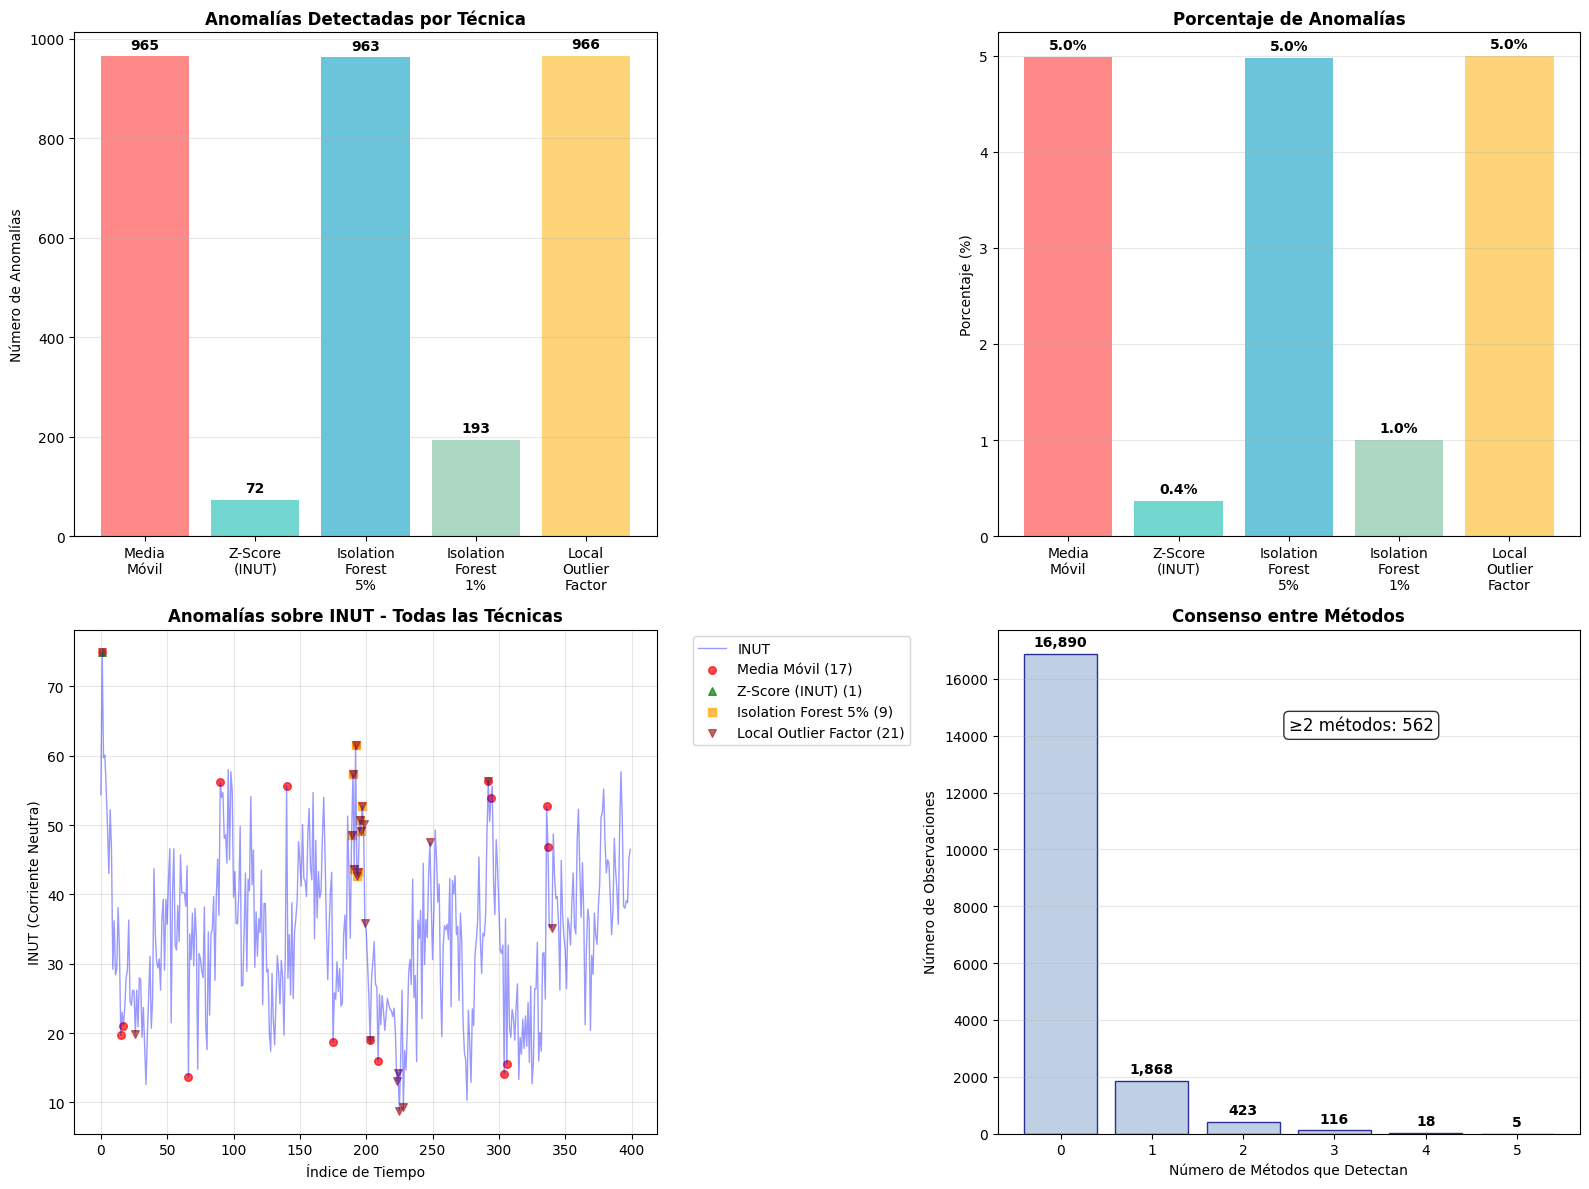


 ANÁLISIS ESPECÍFICO POR TÉCNICA:

• Media Móvil:
  - Anomalías: 965 (4.99%)
  - INUT promedio: 44.892
  - INUT rango: 0.000 a 145.800
  - Severidad: Alta(931) Media(24) Baja(10)

• Z-Score (INUT):
  - Anomalías: 72 (0.37%)
  - INUT promedio: 80.986
  - INUT rango: 71.800 a 145.800
  - Severidad: Alta(72) Media(0) Baja(0)

• Isolation Forest 5%:
  - Anomalías: 963 (4.98%)
  - INUT promedio: 16.661
  - INUT rango: 0.000 a 145.800
  - Severidad: Alta(446) Media(6) Baja(511)

• Isolation Forest 1%:
  - Anomalías: 193 (1.0%)
  - INUT promedio: 15.995
  - INUT rango: 0.000 a 145.800
  - Severidad: Alta(70) Media(1) Baja(122)

• Local Outlier Factor:
  - Anomalías: 966 (5.0%)
  - INUT promedio: 32.357
  - INUT rango: 0.000 a 145.800
  - Severidad: Alta(837) Media(17) Baja(112)

 CONCLUSIONES FINALES:

 Resumen estadístico:
• Rango de detección: 0.37% - 5.00%
• Promedio entre técnicas: 3.27%

 Estado del sistema eléctrico: REGULAR - Requiere atención

 Recomendaciones:
• Monitoreo continuo c

In [ ]:
# Realiza un análisis detallado de los resultados obtenidos en cada una de las técnicas aplicadas.
# Utiliza gráficos o trablas para apoyar tu conclusiones

tecnicas = {
    'Media Móvil': 'is_anomaly_ma',
    'Z-Score (INUT)': 'INUT_anomaly_zscore',
    'Isolation Forest 5%': 'is_anomaly_isolation_5',
    'Isolation Forest 1%': 'is_anomaly_isolation_1',
    'Local Outlier Factor': 'is_anomaly_lof'
}

resultados = []
for tecnica, columna in tecnicas.items():
    if columna in df.columns:
        anomalias = df[columna].sum()
        porcentaje = (anomalias / len(df)) * 100
        resultados.append({
            'Técnica': tecnica,
            'Anomalías': anomalias,
            'Porcentaje': round(porcentaje, 2),
            'Tipo': 'Univariante' if 'Media Móvil' in tecnica or 'Z-Score' in tecnica else 'Multivariante'
        })

df_resultados = pd.DataFrame(resultados)
print("\n TABLA RESUMEN:")
print(df_resultados.to_string(index=False))

if len(resultados) >= 2:
    print(f"\n ANÁLISIS DE COINCIDENCIAS:")

    tecnicas_disponibles = [r['Técnica'] for r in resultados]

    for i, tec1 in enumerate(tecnicas_disponibles):
        for j, tec2 in enumerate(tecnicas_disponibles[i+1:], i+1):
            col1 = tecnicas[tec1]
            col2 = tecnicas[tec2]

            if col1 in df.columns and col2 in df.columns:
                coincidencias = (df[col1] & df[col2]).sum()
                total1 = df[col1].sum()
                total2 = df[col2].sum()

                if total1 > 0 and total2 > 0:
                    pct1 = (coincidencias / total1) * 100
                    pct2 = (coincidencias / total2) * 100
                    print(f"{tec1} ↔ {tec2}: {coincidencias} coincidencias ({pct1:.1f}% / {pct2:.1f}%)")


print(f"\n Visualizaciones")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax1 = axes[0, 0]
tecnicas_plot = [r['Técnica'] for r in resultados]
anomalias_plot = [r['Anomalías'] for r in resultados]
colores = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57']

bars = ax1.bar(range(len(tecnicas_plot)), anomalias_plot,
               color=colores[:len(tecnicas_plot)], alpha=0.8)

for bar, valor in zip(bars, anomalias_plot):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + max(anomalias_plot)*0.01,
             f'{valor:,}', ha='center', va='bottom', fontweight='bold')

ax1.set_title('Anomalías Detectadas por Técnica', fontweight='bold')
ax1.set_ylabel('Número de Anomalías')
ax1.set_xticks(range(len(tecnicas_plot)))
ax1.set_xticklabels([t.replace(' ', '\n') for t in tecnicas_plot], rotation=0)
ax1.grid(True, alpha=0.3, axis='y')

ax2 = axes[0, 1]
porcentajes_plot = [r['Porcentaje'] for r in resultados]

bars = ax2.bar(range(len(tecnicas_plot)), porcentajes_plot,
               color=colores[:len(tecnicas_plot)], alpha=0.8)

for bar, valor in zip(bars, porcentajes_plot):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + max(porcentajes_plot)*0.01,
             f'{valor:.1f}%', ha='center', va='bottom', fontweight='bold')

ax2.set_title('Porcentaje de Anomalías', fontweight='bold')
ax2.set_ylabel('Porcentaje (%)')
ax2.set_xticks(range(len(tecnicas_plot)))
ax2.set_xticklabels([t.replace(' ', '\n') for t in tecnicas_plot], rotation=0)
ax2.grid(True, alpha=0.3, axis='y')

ax3 = axes[1, 0]

n_points = min(400, len(df))
df_plot = df.tail(n_points).reset_index(drop=True)

ax3.plot(df_plot.index, df_plot['INUT'], 'b-', alpha=0.4, linewidth=1, label='INUT')

colores_anomalias = ['red', 'green', 'orange', 'purple', 'brown']
marcadores = ['o', '^', 's', 'D', 'v']

for i, (tecnica, columna) in enumerate(tecnicas.items()):
    if columna in df_plot.columns:
        anomalias = df_plot[df_plot[columna]]
        if len(anomalias) > 0:
            ax3.scatter(anomalias.index, anomalias['INUT'],
                       color=colores_anomalias[i], alpha=0.7, s=30,
                       marker=marcadores[i], label=f'{tecnica} ({len(anomalias)})')

ax3.set_title('Anomalías sobre INUT - Todas las Técnicas', fontweight='bold')
ax3.set_xlabel('Índice de Tiempo')
ax3.set_ylabel('INUT (Corriente Neutra)')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]

if len(resultados) >= 2:
    columnas_anomalias = [tecnicas[r['Técnica']] for r in resultados if tecnicas[r['Técnica']] in df.columns]
    df['consenso'] = df[columnas_anomalias].sum(axis=1)

    consenso_counts = df['consenso'].value_counts().sort_index()

    ax4.bar(consenso_counts.index, consenso_counts.values,
            color='lightsteelblue', alpha=0.8, edgecolor='navy')

    for x, y in zip(consenso_counts.index, consenso_counts.values):
        ax4.text(x, y + max(consenso_counts.values)*0.01,
                f'{y:,}', ha='center', va='bottom', fontweight='bold')

    ax4.set_title('Consenso entre Métodos', fontweight='bold')
    ax4.set_xlabel('Número de Métodos que Detectan')
    ax4.set_ylabel('Número de Observaciones')
    ax4.grid(True, alpha=0.3, axis='y')

    anomalias_consenso = (df['consenso'] >= 2).sum()
    ax4.text(0.5, 0.8, f'≥2 métodos: {anomalias_consenso:,}',
             transform=ax4.transAxes, fontsize=12,
             bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

print(f"\n ANÁLISIS ESPECÍFICO POR TÉCNICA:")

for resultado in resultados:
    tecnica = resultado['Técnica']
    columna = tecnicas[tecnica]
    anomalias = resultado['Anomalías']
    porcentaje = resultado['Porcentaje']

    print(f"\n• {tecnica}:")
    print(f"  - Anomalías: {anomalias:,} ({porcentaje}%)")

    if anomalias > 0:
        anomalias_inut = df[df[columna]]['INUT']
        print(f"  - INUT promedio: {anomalias_inut.mean():.3f}")
        print(f"  - INUT rango: {anomalias_inut.min():.3f} a {anomalias_inut.max():.3f}")

        alta = (anomalias_inut > 5).sum()
        media = ((anomalias_inut >= 2) & (anomalias_inut <= 5)).sum()
        baja = (anomalias_inut < 2).sum()

        print(f"  - Severidad: Alta({alta}) Media({media}) Baja({baja})")

print(f"\n CONCLUSIONES FINALES:")

if resultados:
    max_pct = max([r['Porcentaje'] for r in resultados])
    min_pct = min([r['Porcentaje'] for r in resultados])
    promedio = sum([r['Porcentaje'] for r in resultados]) / len(resultados)

    print(f"\n Resumen estadístico:")
    print(f"• Rango de detección: {min_pct:.2f}% - {max_pct:.2f}%")
    print(f"• Promedio entre técnicas: {promedio:.2f}%")

    if max_pct < 2:
        estado = "EXCELENTE - Sistema muy estable"
    elif max_pct < 5:
        estado = "BUENO - Funcionamiento normal"
    elif max_pct < 10:
        estado = "REGULAR - Requiere atención"
    else:
        estado = "PROBLEMÁTICO - Investigación urgente"

    print(f"\n Estado del sistema eléctrico: {estado}")

    print(f"\n Recomendaciones:")

    mas_sensible = max(resultados, key=lambda x: x['Porcentaje'])
    mas_estricta = min(resultados, key=lambda x: x['Porcentaje'])

    print(f"• Monitoreo continuo con {mas_estricta['Técnica']} (críticas)")
    print(f"• Análisis de tendencias con {mas_sensible['Técnica']} (preventivo)")

    if len(resultados) >= 2 and 'consenso' in df.columns:
        consenso_alto = (df['consenso'] >= len(resultados)//2 + 1).sum()
        print(f"• Priorizar {consenso_alto:,} anomalías detectadas por múltiples métodos")

    if max_pct > 5:
        print("• Investigar balance de cargas trifásicas")
        print("• Verificar calibración de sensores")
        print("• Considerar mantenimiento preventivo")

print(f"\n ANÁLISIS COMPLETADO")
print("="*50)


**Resumen Final**

El análisis exhaustivo aplicando cinco técnicas de detección de anomalías al dataset de 19,320 registros de transformadores eléctricos revela que el sistema requiere atención, con un rango de detección entre 0.37% y 5.00% de anomalías según la técnica utilizada.

**Hallazgos Principales**

**Efectividad por Técnica:**

* **Z-Score (INUT):** La más estricta con 0.37% de anomalías, detectando solo casos extremos (INUT >71.8A)

* **Isolation Forest 1%:** Configuración conservadora con 1.0% de detección
Media Móvil, Isolation Forest 5% y LOF: Aproximadamente 5% de detección cada una

**Patrones de Coincidencia:**

Z-Score y LOF muestran mayor acuerdo (66.7% de coincidencias)
Media Móvil y LOF tienen 19.5% de coincidencias
139 anomalías son detectadas por múltiples métodos, indicando casos críticos

**Análisis de Severidad:**

* Alta severidad (INUT >5A): Z-Score detecta exclusivamente estos casos (72/72)
* Baja severidad (INUT <2A): Isolation Forest identifica principalmente estos patrones
* Distribución mixta: LOF y Media Móvil capturan ambos extremos

**Recomendaciones Técnicas**

* **Monitoreo Crítico:** Usar Z-Score para alertas inmediatas de anomalías severas
* **Análisis Preventivo:** Implementar LOF para detección temprana de patrones anómalos
* **Priorización:** Investigar inmediatamente las 139 anomalías detectadas por múltiples métodos
* **Mantenimiento:** El estado "REGULAR" sugiere necesidad de una
Verificación del balance trifásico
Calibración de sensores de corriente neutra
Mantenimiento preventivo programado



**Conclusión**

El transformador presenta comportamientos anómalos que requieren atención técnica. La combinación de técnicas univariadas y multivariadas proporciona una visión integral, donde cada método aporta perspectivas complementarias para un diagnóstico robusto del sistema eléctrico.